- [x]  Train Accuracy & Test Accuracy vs Epochs  
- [x]  Saturated Train Accuracy vs. Num_clients  
- [x]  Saturated Testing Accuracy vs. Num_Clients  
- [x]  Training accuracy vs Each client bar graph  
- [x]  Testing accuracy vs Each client bar graph  
- [x]  Generalising for multiple users  
- [x]  Accuracy per user  
- [x]  Different datasets  
- [x]  All of these for CNN model  
- [x]  How many parameters are being passed  
- [x]  Max batch size for each client  
- [x]  Calculate network overhead and computation per user  
- [x]  Transfer learning  
- [ ]  Trying on pregnancy data and breast cancer dataset

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
from math import prod
import random
import numpy as np
from sklearn.metrics import normalized_mutual_info_score

In [3]:
# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Hyper-parameters
input_size = 784
hidden_size1 = 500
hidden_size2 = 200
num_classes = 10
num_epochs = 5
learning_rate = 0.01
max_batch_size = 50
transfer_learning = False
pretrained_model_path = "./models/model1/"
num_iters = 5
weight_flag =0
num_clients = 10

In [5]:
# MNIST dataset

# !wget www.di.ens.fr/~lelarge/MNIST.tar.gz
# !tar -zxvf MNIST.tar.gz ../../data

# train_dataset = torchvision.datasets.MNIST(root='../../data',
#                                            train=True,
#                                            transform=transforms.ToTensor(),download=True)

# test_dataset = torchvision.datasets.MNIST(root='../../data',
#                                           train=False,
#                                           transform=transforms.ToTensor())


# train_batch_size = len(train_dataset)//num_clients
# train_split = [train_batch_size]*(num_clients-1)
# train_split.append(len(train_dataset)-train_batch_size*(num_clients-1))

# test_batch_size = len(test_dataset)//num_clients
# test_split = [test_batch_size]*(num_clients-1)
# test_split.append(len(test_dataset)-test_batch_size*(num_clients-1))

# train_datasets = list(torch.utils.data.random_split(train_dataset, train_split))
# test_datasets = list(torch.utils.data.random_split(test_dataset, test_split))

# # Data loaders
# train_loaders = []
# for train_dataset in train_datasets:
#     train_loaders.append(torch.utils.data.DataLoader(dataset=train_dataset,
#                                                 batch_size=train_batch_size,
#                                                 shuffle=True))

# test_loaders = []
# for test_dataset in test_datasets:
#     test_loaders.append(torch.utils.data.DataLoader(dataset=test_dataset,
#                                                 batch_size=test_batch_size,
#                                                 shuffle=True))

In [6]:
from data_loader import DATALOADER
from dataset import DATASET

In [12]:
# train_dataset, test_dataset = DATASET.MNIST()
train_dataset, test_dataset = DATASET.CIFAR10()

Files already downloaded and verified


In [ ]:
train_loaders = DATALOADER.train_dataloader(num_clients, train_dataset)
test_loaders = DATALOADER.test_dataloader(num_clients, test_dataset)

In [8]:
print(len(test_dataset))

10000


In [9]:
examples = iter(test_loaders[0])
example_data, example_targets = examples.next()
print(example_data.shape, example_targets.shape)

torch.Size([1000, 3, 32, 32]) torch.Size([1000])


In [10]:
print(example_targets[1])

tensor(1)


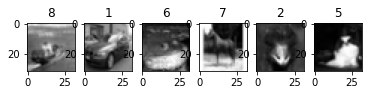

In [11]:
for i in range(6):
    plt.subplot(1,6,i+1)
    plt.title(example_targets[i].item())
    plt.imshow(example_data[i][0], cmap='gray')
plt.show()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
def random_dataset(client):
    images, labels = iter(train_loaders[client]).next()
    images = images.reshape(-1, 784).to(device)
    labels = labels.to(device)        

    if max_batch_size < labels.shape[0]:
        random_indices = [random.randint(0, labels.shape[0]) for i in range(max_batch_size)]
        # print(random_indices)
        images = images[random_indices]
        labels = labels[random_indices]
    return images, labels

In [12]:
def get_start(startModels):
    if transfer_learning == True:
        for i in range(num_clients):
            startModels.append(torch.load(pretrained_model_path + "/starting_model").to(device))

    else:
        class ClientStartNN(nn.Module):
            def __init__(self, input_size, hidden_size1):
                super(ClientStartNN, self).__init__()
                self.l1 = nn.Linear(input_size, hidden_size1)
                self.relu = nn.ReLU()

            def forward(self, x):
                out = self.l1(x)
                out = self.relu(out)
                return out

        for i in range(num_clients):
            startModels.append(ClientStartNN(input_size, hidden_size1).to(device))
    return startModels

In [13]:
# def get_startmodel(num_iter, startModels, percentage_loss, flag):
#     # two tensors for the new averaged weights for startModels
#     k=0
#     for parameters in startModels[0].parameters():
#         if(k == 0):
#             new_params1 = parameters
#         else:
#             new_params2 = parameters
        # k =k+1
    # averaged weights of the startModels 
    # k =0
    # for i  in range(num_clients):
    #     k =0
    #     for parameters in  startModels[i].parameters():
    #         if(k == 0):
    #             if(flag ==1):
    #                 new_params1 = new_params1 + parameters*percentage_loss[i] 
    #             new_params1 = new_params1 + parameters 
    #         else:
    #             if(flag ==1):
    #                 new_params2 = new_params2 + parameters*percentage_loss[i] 
    #             new_params2 = new_params2 + parameters 
    #         k =k+1
    # new_params1 =[number1/num_clients for number1 in new_params1] 
    # new_params2 = [number2/num_clients for number2 in new_params2]
    # if transfer_learning == True:
    #     for i in range(num_clients):
    #         startModels.append(torch.load(pretrained_model_path + "/starting_model").to(device))

    # else:
    #     class ClientStartNN(nn.Module):
    #         def __init__(self, input_size, hidden_size1):
    #             super(ClientStartNN, self).__init__()
    #             self.l1 = nn.Linear(input_size, hidden_size1)
    #             self.relu = nn.ReLU()

    #         def forward(self, x):
    #             out = self.l1(x)
    #             out = self.relu(out)
    #             return out
    #         k =0
    #     for sample in ClientStartNN(input_size, hidden_size1).parameters():
    #         if (k ==0):
    #             ClientStartNN.parameters = new_params1
    #         else:
    #             ClientStartNN.parameters = new_params2
    #         k =k+1
    #     for i in range(num_clients):
    #         startModels.append(ClientStartNN(input_size, hidden_size1).to(device))
    # return startModels

In [14]:
from averaged_models import AVERAGEDMODELS

In [26]:
def averagestartm(startModels):    
    ClientStartNN = AVERAGEDMODELS.startaverage(startModels, num_clients, input_size, hidden_size1)
    for i in range(num_clients):
        startModels.append(ClientStartNN)
    return startModels

In [16]:
if transfer_learning == True:
    serverModel = torch.load(pretrained_model_path + "/middle_model").to(device)

else:
    class ServerNN(nn.Module):
        def __init__(self, hidden_size1, hidden_size2):
            super(ServerNN, self).__init__()
            self.l2 = nn.Linear(hidden_size1, hidden_size2)
            self.relu = nn.ReLU()
        
        def forward(self, x):
            out = self.l2(x)
            out = self.relu(out)
            return out

    serverModel = ServerNN(hidden_size1, hidden_size2).to(device)

In [17]:
def get_end(endModels):
    if transfer_learning == True:
        for i in range(num_clients):
            endModels.append(torch.load(pretrained_model_path + "/ending_model").to(device))

    else:
        class ClientEndNN(nn.Module):
            def __init__(self, hidden_size2, num_classes):
                super(ClientEndNN, self).__init__()
                self.input_size = input_size
                self.l1 = nn.Linear(hidden_size2, num_classes)
            
            def forward(self, x):
                out = self.l1(x)
                return out


        for i in range(num_clients):
            endModels.append(ClientEndNN(hidden_size2, num_classes).to(device))
    return endModels

In [18]:
# def get_endmodel(num_iter, endModels, percentage_loss, flag):
    # k=0
    # for parameters in endModels[0].parameters():
    #     if(k == 0):
    #         new_params3 = parameters
    #     else:
    #         new_params4 = parameters
    #     k =k+1
    # # averaged weights of the endModels 
    # k =0
    # for i  in range(num_clients):
    #     k =0
    #     for parameters in  endModels[i].parameters():
    #         if(k == 0):
    #             if(flag ==1):
    #                 new_params3 = new_params3 + parameters*percentage_loss[i] 
    #             new_params3 = new_params3 + parameters
    #         else:
    #             if(flag == 0):
    #                 new_params4 = new_params4 + parameters*percentage_loss[i]
    #             new_params4 = new_params4 + parameters
    #         k = k+1
    # new_params3 =[number3/num_clients for number3 in new_params3]
    # new_params4 = [number4/num_clients for number4 in new_params4]
    # if transfer_learning == True:
    #     for i in range(num_clients):
    #         endModels.append(torch.load(pretrained_model_path + "/ending_model").to(device))

    # else:
    #     class ClientEndNN(nn.Module):
    #         def __init__(self, hidden_size2, num_classes):
    #             super(ClientEndNN, self).__init__()
    #             self.input_size = input_size
    #             self.l1 = nn.Linear(hidden_size2, num_classes)
            
    #         def forward(self, x):
    #             out = self.l1(x)
    #             return out
    #         k =0
    #     for sample in ClientEndNN(hidden_size2, num_classes).parameters():
    #         if (k ==0):
    #             ClientEndNN.parameters = new_params3
    #         else:
    #             ClientEndNN.parameters = new_params4
    #         k= k+1
    #     for i in range(num_clients):
    #         endModels.append(ClientEndNN(hidden_size2, num_classes).to(device))
    # return endModels

In [19]:
def averageendm(endModels):    
    ClientendNN = AVERAGEDMODELS.endaverage(endModels, num_clients, input_size, hidden_size2, num_classes)
    for i in range(num_clients):
        endModels.append(ClientendNN)
    return endModels

In [20]:
# loss
criterion = nn.CrossEntropyLoss()

# optimizer
def get_optimizers(startModels, endModels):
    startOptimizers = []
    for i in range(num_clients):
        startOptimizers.append(torch.optim.Adam(startModels[i].parameters(), lr=learning_rate))
    serverOptimizer = torch.optim.Adam(serverModel.parameters(), lr=learning_rate)
    endOptimizers = []
    for i in range(num_clients):
        endOptimizers.append(torch.optim.Adam(endModels[i].parameters(), lr=learning_rate))
    return startOptimizers, endOptimizers, serverOptimizer

In [21]:
def mergeGrad(params):
    # params = [params_client1,
    #           params_client2,
    #           params_client3,
    #           ...
    #          ]
    for col in zip(*params):
        avg = 0
        for param in col:
            avg += param.grad
        avg /= num_clients
        for param in col:
            param.grad = avg.clone()

In [22]:
def get_averagednmis(nmis):
    out = nmis[0: num_clients]
    for i in range(1,num_epochs):
        a = i*num_clients
        sample = nmis[a: a+num_clients]
        for j in range(num_clients):
            out[j] = sample[j] + out[j]
    out = [number / num_epochs for number in out]
    return out

In [23]:
images_dataset = []
labels_dataset = []
for i in range(num_clients):
    images, labels = random_dataset(i)
    images_dataset.append(images)
    labels_dataset.append(labels)

In [27]:
# training loop
# total_train_acc = []
# total_test_acc = []

"""
bandwidth_cost is a 3D numpy array with depth 4.
Depth is 4 because it stores bandwidth cost for:
activations from client to server at index 0,
activations from server to client at index 1,
gradients from client to server at index 2,
gradients from server to client at index 3.
"""
# bandwidth_cost = np.zeros([num_clients, num_epochs, 4])

# To get bandwidth cost for sending activations 
# from server to client 50 in epoch 10, execute bandwidth_cost[50][10][1].
startModels =[]
endModels =[]
startModels = get_start(startModels)
endModels = get_end(endModels)
for num_iter in range(num_iters):
    print(f'{num_iter+1} iteration')
    bandwidth_cost = np.zeros([num_clients, num_epochs, 4])
    total_train_acc = []
    total_test_acc = []
    losses = []
    nmis =[]
    startOptimizers, endOptimizers, serverOptimizer = get_optimizers(startModels, endModels)
    for epoch in range(num_epochs):
        grads = []
        # losses = []
        entropies = []
        n_correct = 0
        test_n_correct = 0
        n_samples = []
        n_samples = 0
        test_n_samples = 0
        per_clientacc =[0]*num_clients
        for client in range(num_clients):
            images = images_dataset[client]
            labels = labels_dataset[client]
            # entropy_client = entropy(labels)
            # entropies.append(entropy_client)

            ## Forward
            # Forward through starting layers (with client 1)
            activations1 = startModels[client](images)
            remote_activations1 = activations1.detach().requires_grad_(True)      



            #### Pass remote_activations1 to server here
            
            ############################################



            # Storing the bandwidth cost for activations of client sending th server
            bandwidth_cost[client][epoch][0] = prod(remote_activations1.shape)

            # Forward through middle layers (with server) 
            activations2 = serverModel(remote_activations1)
            remote_activations2 = activations2.detach().requires_grad_(True)



            #### Pass remote_activations2 to corresponding client here

            ##########################################################



            # Storing the bandwidth cost for activations of server sending to client
            bandwidth_cost[client][epoch][1] = prod(remote_activations2.shape)

            # Forward through ending layers (with client 1)
            outputs = endModels[client](remote_activations2)


            # loss
            loss = criterion(outputs, labels)
            losses.append(loss.item())


            # Calculating Train Accuracy
            with torch.no_grad():
                _, predicted = torch.max(outputs.data, 1)
                n_correct += (predicted == labels).sum().item()
                n_samples += labels.size(0)
            
            # Calculating Test Accuracy
            # This section drastically decreases training speed due to added forward prop in each iteration
            with torch.no_grad():
                test_images, test_labels = iter(test_loaders[client]).next()
                test_images = test_images.reshape(-1, 784).to(device)
                test_labels = test_labels.to(device)

                ## Forward
                # Forward through starting layers (with client 1)
                test_activations1 = startModels[client](test_images)
                test_remote_activations1 = test_activations1.detach().requires_grad_(True) 

                # Forward through middle layers (with server) 
                test_activations2 = serverModel(test_remote_activations1)
                test_remote_activations2 = test_activations2.detach().requires_grad_(True)

                # Forward through ending layers (with client 1)
                test_outputs = endModels[client](test_remote_activations2)

                # value, index
                _, test_predicted = torch.max(test_outputs.data, 1)
                test_n_correct += (test_predicted == test_labels).sum().item()
                test_n_samples += test_labels.size(0)

            per_clientaccs = test_n_correct/test_n_samples
            per_clientacc[client]= per_clientaccs*100

            # Zeroing out all gradients
            startOptimizers[client].zero_grad()
            serverOptimizer.zero_grad()
            endOptimizers[client].zero_grad()

            # Back-propagation on ending model at client side
            loss.backward()



            #### Pass remote_activations2.grad to the server here

            #####################################################
            

            
            # Storing bandwidth cost for client sending gradients to server
            bandwidth_cost[client][epoch][2] = prod(remote_activations2.grad.shape)

            # Backpropagation on server without updating weights
            activations2.backward(remote_activations2.grad)



            #### Pass remote_activations1.grad to the corresponding clients here

            ####################################################################


            # Storing bandwidth cost for server sending gradients to client
            bandwidth_cost[client][epoch][3] = prod(remote_activations1.grad.shape)

            # Backpropatation of starting model at client
            activations1.backward(remote_activations1.grad)

            # Updating weights of starting model at client
            startOptimizers[client].step()

            # Storing gradients at the server
            grads.append(serverModel.parameters())

            # Updating weights of ending model at client
            endOptimizers[client].step()

            nmi =normalized_mutual_info_score(test_labels, test_predicted, average_method='arithmetic')
            nmis.append(nmi.item())
        
            # print(f'NMI in epoch {epoch+1} for client {client+1} : {nmi}')

        # Taking average of gradients at the server
        mergeGrad(grads)

        # Updating weights based on gradients at the server
        serverOptimizer.step()

        a = num_clients*(epoch)
        
        total_train_acc.append(100.0 * n_correct / n_samples)
        total_test_acc.append(100.0 * test_n_correct / test_n_samples)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]: Avg Loss: {sum(losses[a:a+10])/num_clients:.4f}, Total Train Accuracy: {total_train_acc[-1]:.4f}, Total Test Accuracy: {total_test_acc[-1]:.4f}')
    

    l1 = losses[0:10]
    l10 = losses[40:50]
    percentage_loss =[0]*num_clients
    for j in range(num_clients):
        percentage_loss[j] = l1[j] - l10[j]
        if(l1[j] !=0):
            percentage_loss[j] = percentage_loss[j]/l1[j]
        print(f'percentage loss for client {j+1}: {percentage_loss[j]:.4f}')

    nmi_average = get_averagednmis(nmis)
    for k in range(num_clients):
        print(f'nmi for client {k+1}: {nmi_average[k]:.4f}')
    for k in range(0, num_clients):
        print(f'test accuracy for client {k+1}: {per_clientacc[k]:.4f}')
    # startModels = get_startmodel(num_iter, startModels, percentage_loss, weight_flag)
    startModels = averagestartm(startModels)
    # endModels = get_endmodel(num_iter, endModels, percentage_loss, weight_flag)
    endModels = averageendm(endModels)


1 iteration
Epoch [1/5]: Avg Loss: 2.3134, Total Train Accuracy: 10.4000, Total Test Accuracy: 9.7300
Epoch [2/5]: Avg Loss: 1.9904, Total Train Accuracy: 36.2000, Total Test Accuracy: 19.8700
Epoch [3/5]: Avg Loss: 1.5184, Total Train Accuracy: 58.4000, Total Test Accuracy: 33.7400
Epoch [4/5]: Avg Loss: 1.0954, Total Train Accuracy: 80.2000, Total Test Accuracy: 47.9000
Epoch [5/5]: Avg Loss: 0.6789, Total Train Accuracy: 90.6000, Total Test Accuracy: 54.2900
percentage loss for client 1: 0.5811
percentage loss for client 2: 0.5333
percentage loss for client 3: 0.6472
percentage loss for client 4: 0.7113
percentage loss for client 5: 0.7846
percentage loss for client 6: 0.7501
percentage loss for client 7: 0.7465
percentage loss for client 8: 0.7680
percentage loss for client 9: 0.7438
percentage loss for client 10: 0.8004
nmi for client 1: 0.1927
nmi for client 2: 0.3141
nmi for client 3: 0.2470
nmi for client 4: 0.3098
nmi for client 5: 0.2819
nmi for client 6: 0.2760
nmi for clien

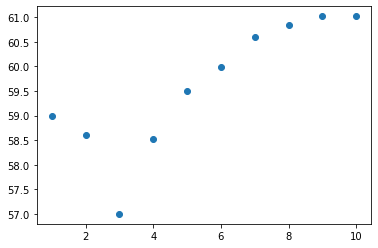

In [62]:
x =[1,2,3,4,5,6,7,8,9,10]
y = per_clientacc
plt.scatter(x, y)
plt.show()

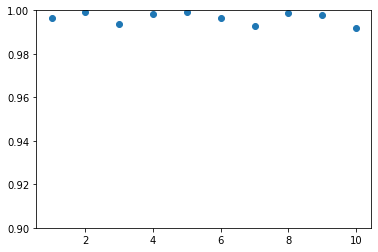

In [66]:
y = percentage_loss
plt.ylim(0.900, 1)
plt.scatter(x, y)
plt.show()

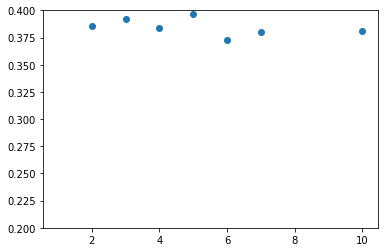

In [67]:
y = nmi_average
plt.ylim(0.20, 0.40)
plt.scatter(x, y)
plt.show()

In [82]:
# test = [0]*2
# for param in startModels[0].parameters():
#     test[0] = param
#     print(type(param))
# test1 = sum(test)/2
